In [27]:
import os
import numpy as np
import pandas as pd
import cv2
import random
import time
import psutil
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
from pathlib import Path
import pickle

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn.functional as F

In [28]:
# GPU configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")


Using device: cuda
GPU: NVIDIA GeForce RTX 2080
CUDA version: 11.8
Memory: 7.6 GB


In [29]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)


IMG_SIZE = 224  # EfficientNet-B0 standard input size
BATCH_SIZE = 32
EPOCHS = 100
VALIDATION_SPLIT = 0.3

# EfficientNet specific configuration
EFFICIENTNET_CONFIG = {
    'base_learning_rate': 0.001,
    'fine_tune_learning_rate': 0.0001,
    'dropout_rate': 0.5,
    'fine_tune_layers': 20,
    'weight_decay': 1e-4
}

# Emotion labels mapping
EMOTION_LABELS = {
    'Raiva': 0, 'Nojo': 1, 'Medo': 2, 'Felicidade': 3, 
    'Neutro': 4, 'Tristeza': 5, 'Surpresa': 6
}


In [30]:
class EmotionDataset(Dataset):
    """""Custom dataset for emotion classification"""""
    
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert numpy array to PIL Image format for transforms
        if isinstance(image, np.ndarray):
            # Ensure image is in uint8 format [0, 255]
            if image.max() <= 1.0:
                image = (image * 255).astype(np.uint8)
            else:
                image = image.astype(np.uint8)
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)

In [31]:
class EfficientNetEmotionClassifier(nn.Module):
    """EfficientNet-B0 model for emotion classification"""
    
    def __init__(self, num_classes=7, dropout_rate=0.5):
        super(EfficientNetEmotionClassifier, self).__init__()
        
        # Load pre-trained EfficientNet-B0
        self.backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        # Replace the classifier
        num_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()  # Remove original classifier
        
        # Custom classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),  # Feature dropout (similar to drop_connect)
            nn.Linear(num_features, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
        # Initialize custom layers
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize custom classifier weights"""
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Extract features
        features = self.backbone(x)
        # Classify
        output = self.classifier(features)
        return output
    
    def freeze_backbone(self):
        """Freeze backbone for feature extraction phase"""
        for param in self.backbone.parameters():
            param.requires_grad = False
    
    def unfreeze_backbone(self, num_layers_to_unfreeze=20):
        """Unfreeze last layers for fine-tuning"""
        # Get all backbone parameters
        backbone_params = list(self.backbone.parameters())
        
        # Unfreeze last num_layers_to_unfreeze parameters
        for param in backbone_params[-num_layers_to_unfreeze:]:
            param.requires_grad = True

In [32]:
class EfficientNetMonitor:
    """Monitor for EfficientNet training"""
    
    def __init__(self):
        self.start_time = None
        self.end_time = None
        self.peak_memory_mb = 0
        self.initial_memory_mb = 0
        self.phase1_time = 0
        self.phase2_time = 0
        self.process = psutil.Process()
        self.training_phases = {'phase1': None, 'phase2': None}
        
    def start_monitoring(self):
        """Start monitoring"""
        self.start_time = time.time()
        self.initial_memory_mb = self._get_memory_usage()
        self.peak_memory_mb = self.initial_memory_mb
        print(f"Starting EfficientNet-B0 training...")
        print(f"Start time: {time.strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Initial memory: {self.initial_memory_mb:.2f} MB")
        print(f"Device: {device}")
        print("-" * 50)
        
    def start_phase(self, phase_name):
        """Start a training phase"""
        self.training_phases[phase_name] = time.time()
        print(f"Starting {phase_name} - EfficientNet")
        
    def end_phase(self, phase_name):
        """End a training phase"""
        if self.training_phases[phase_name] is not None:
            phase_duration = time.time() - self.training_phases[phase_name]
            if phase_name == 'phase1':
                self.phase1_time = phase_duration
            elif phase_name == 'phase2':
                self.phase2_time = phase_duration
            print(f"{phase_name} completed in: {timedelta(seconds=int(phase_duration))}")
            return phase_duration
        return 0
        
    def _get_memory_usage(self):
        """Get current memory usage in MB"""
        return self.process.memory_info().rss / 1024 / 1024
        
    def update_peak_memory(self):
        """Update peak memory if necessary"""
        current_memory = self._get_memory_usage()
        if current_memory > self.peak_memory_mb:
            self.peak_memory_mb = current_memory
            
    def get_efficiency_metrics(self):
        """Calculate efficiency metrics"""
        current_memory = self._get_memory_usage()
        total_time = self.phase1_time + self.phase2_time
        
        return {
            'memory_efficiency': self.initial_memory_mb / self.peak_memory_mb if self.peak_memory_mb > 0 else 0,
            'time_efficiency': total_time / 3600,  # Hours
            'peak_memory_gb': self.peak_memory_mb / 1024,
            'memory_growth_factor': self.peak_memory_mb / self.initial_memory_mb if self.initial_memory_mb > 0 else 1,
            'phase1_ratio': self.phase1_time / total_time if total_time > 0 else 0,
            'phase2_ratio': self.phase2_time / total_time if total_time > 0 else 0
        }
        
    def end_monitoring(self):
        """End monitoring and return statistics"""
        self.end_time = time.time()
        
        total_time_seconds = self.end_time - self.start_time
        total_time_formatted = str(timedelta(seconds=int(total_time_seconds)))
        
        final_memory_mb = self._get_memory_usage()
        memory_increase = final_memory_mb - self.initial_memory_mb
        
        efficiency_metrics = self.get_efficiency_metrics()
        
        print("\n" + "="*70)
        print("EFFICIENTNET-B0 MONITORING REPORT")
        print("="*70)
        print(f"Total training time: {total_time_formatted}")
        print(f"  • Phase 1 (Base layers): {timedelta(seconds=int(self.phase1_time))}")
        print(f"  • Phase 2 (Fine-tuning): {timedelta(seconds=int(self.phase2_time))}")
        print(f"Initial memory: {self.initial_memory_mb:.2f} MB")
        print(f"Final memory: {final_memory_mb:.2f} MB")
        print(f"Peak memory: {self.peak_memory_mb:.2f} MB")
        print(f"Memory efficiency: {efficiency_metrics['memory_efficiency']:.3f}")
        print(f"Growth factor: {efficiency_metrics['memory_growth_factor']:.2f}x")
        print("="*70)
        
        return {
            'total_time_seconds': total_time_seconds,
            'total_time_formatted': total_time_formatted,
            'initial_memory_mb': self.initial_memory_mb,
            'final_memory_mb': final_memory_mb,
            'peak_memory_mb': self.peak_memory_mb,
            'memory_increase_mb': memory_increase,
            'phase1_time': self.phase1_time,
            'phase2_time': self.phase2_time,
            'efficiency_metrics': efficiency_metrics
        }


In [33]:
def load_preprocessed_data_efficientnet_from_images():
    """Load preprocessed data from images for EfficientNet"""
    print("Loading preprocessed JPG data for EfficientNet...")
    
    BASE_PATH = r"../data/raw/RAF-DB/DATASET"
    
    def load_images_from_directory(directory_path, set_name):
        """Load images from directory"""
        images = []
        labels = []
        
        print(f"Loading {set_name} from: {directory_path}")
        
        if not os.path.exists(directory_path):
            print(f"❌ Directory not found: {directory_path}")
            return np.array([]), np.array([])
        
        subdirs = [d for d in os.listdir(directory_path) 
                  if os.path.isdir(os.path.join(directory_path, d))]
        
        print(f"📁 Subdirectories found: {subdirs}")
        
        for emotion, label in EMOTION_LABELS.items():
            emotion_path = os.path.join(directory_path, emotion)
            
            if not os.path.exists(emotion_path):
                print(f"⚠️  Folder '{emotion}' not found in {directory_path}")
                continue
            
            count = 0
            image_files = []
            
            # Search for different extensions
            for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
                import glob
                pattern = os.path.join(emotion_path, ext)
                image_files.extend(glob.glob(pattern))
            
            print(f"  📸 {emotion}: {len(image_files)} files found")
            
            for img_file in image_files:
                try:
                    # Load image
                    img = cv2.imread(img_file)
                    if img is None:
                        continue
                    
                    # Convert BGR to RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    
                    # Resize if necessary
                    if img.shape[:2] != (IMG_SIZE, IMG_SIZE):
                        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
                    
                    # Ensure RGB (3 channels)
                    if len(img.shape) == 2:
                        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                    elif img.shape[2] == 1:
                        img = np.repeat(img, 3, axis=2)
                    elif img.shape[2] == 4:  # RGBA
                        img = img[:, :, :3]  # Remove alpha channel
                    
                    images.append(img)
                    labels.append(label)
                    count += 1
                    
                except Exception as e:
                    print(f"    ❌ Error loading {os.path.basename(img_file)}: {e}")
                    continue
            
            print(f"  ✅ {emotion}: {count} images loaded successfully")
        
        return np.array(images), np.array(labels)
    
    try:
        # Load train and test data
        train_path = os.path.join(BASE_PATH, "train")
        test_path = os.path.join(BASE_PATH, "test")
        
        X_train, y_train = load_images_from_directory(train_path, "TRAIN")
        X_test, y_test = load_images_from_directory(test_path, "TEST")
        
        if len(X_train) == 0 or len(X_test) == 0:
            print("❌ No images loaded. Check paths and folder names!")
            return None, None, None, None
        
        print(f"\n📊 Data loaded successfully:")
        print(f"- X_train: {X_train.shape}")
        print(f"- y_train: {y_train.shape}")
        print(f"- X_test: {X_test.shape}")
        print(f"- y_test: {y_test.shape}")
        
        # Verify final format
        print(f"\n🔍 Final verification:")
        print(f"- X_train range: [{X_train.min():.3f}, {X_train.max():.3f}]")
        print(f"- X_test range: [{X_test.min():.3f}, {X_test.max():.3f}]")
        print(f"- Image format: {X_train.shape[1:]} (should be {IMG_SIZE}x{IMG_SIZE}x3)")
        
        return X_train, y_train, X_test, y_test
        
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None, None, None, None


In [34]:
def get_transforms():
    """Get transforms for training and validation"""
    # Training transforms with augmentation
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])
    
    # Validation/test transforms (no augmentation)
    val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])
    
    return train_transform, val_transform

def create_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test):
    """Create PyTorch data loaders"""
    train_transform, val_transform = get_transforms()
    
    # Create datasets
    train_dataset = EmotionDataset(X_train, y_train, transform=train_transform)
    val_dataset = EmotionDataset(X_val, y_val, transform=val_transform)
    test_dataset = EmotionDataset(X_test, y_test, transform=val_transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
    
    return train_loader, val_loader, test_loader

def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        if batch_idx % 50 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}, '
                  f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    val_loss /= len(val_loader)
    val_acc = 100. * correct / total
    
    return val_loss, val_acc


In [35]:
def train_efficientnet_two_phase(model, train_loader, val_loader, monitor):
    """Train EfficientNet in two phases"""
    print("="*60)
    print("STARTING EFFICIENTNET 2-PHASE TRAINING")
    print("="*60)
    
    # Phase 1: Feature extraction
    print("PHASE 1: FEATURE EXTRACTION")
    print("-" * 40)
    monitor.start_phase('phase1')
    
    # Freeze backbone
    model.freeze_backbone()
    
    # Setup optimizer and criterion for phase 1
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=EFFICIENTNET_CONFIG['base_learning_rate'], 
                          weight_decay=EFFICIENTNET_CONFIG['weight_decay'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    # Training phase 1
    best_val_acc_phase1 = 0
    phase1_epochs = 30
    
    history_phase1 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(phase1_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch + 1)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        scheduler.step(val_loss)
        
        history_phase1['train_loss'].append(train_loss)
        history_phase1['train_acc'].append(train_acc)
        history_phase1['val_loss'].append(val_loss)
        history_phase1['val_acc'].append(val_acc)
        
        if val_acc > best_val_acc_phase1:
            best_val_acc_phase1 = val_acc
        
        if epoch % 5 == 0:
            print(f'Phase 1 - Epoch {epoch+1}: Train Loss: {train_loss:.4f}, '
                  f'Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    phase1_duration = monitor.end_phase('phase1')
    print(f"Phase 1 - Best val_accuracy: {best_val_acc_phase1:.4f}")
    
    # Phase 2: Fine-tuning
    print("\nPHASE 2: FINE-TUNING")
    print("-" * 40)
    monitor.start_phase('phase2')
    
    # Unfreeze backbone layers
    model.unfreeze_backbone(EFFICIENTNET_CONFIG['fine_tune_layers'])
    
    # Setup optimizer for phase 2 with lower learning rate
    optimizer = optim.Adam(model.parameters(), lr=EFFICIENTNET_CONFIG['fine_tune_learning_rate'], 
                          weight_decay=EFFICIENTNET_CONFIG['weight_decay'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=8, factor=0.3)
    
    # Training phase 2
    best_val_acc_phase2 = 0
    phase2_epochs = EPOCHS - phase1_epochs
    
    history_phase2 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(phase2_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch + 1)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        scheduler.step(val_loss)
        
        history_phase2['train_loss'].append(train_loss)
        history_phase2['train_acc'].append(train_acc)
        history_phase2['val_loss'].append(val_loss)
        history_phase2['val_acc'].append(val_acc)
        
        if val_acc > best_val_acc_phase2:
            best_val_acc_phase2 = val_acc
            # Save best model
            torch.save(model.state_dict(), 'best_efficientnet_model.pth')
        
        if epoch % 5 == 0:
            print(f'Phase 2 - Epoch {epoch+1}: Train Loss: {train_loss:.4f}, '
                  f'Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    phase2_duration = monitor.end_phase('phase2')
    print(f"Phase 2 - Best val_accuracy: {best_val_acc_phase2:.4f}")
    
    # Combine histories
    combined_history = {
        'train_loss': history_phase1['train_loss'] + history_phase2['train_loss'],
        'train_acc': history_phase1['train_acc'] + history_phase2['train_acc'],
        'val_loss': history_phase1['val_loss'] + history_phase2['val_loss'],
        'val_acc': history_phase1['val_acc'] + history_phase2['val_acc'],
        'phase1_epochs': phase1_epochs,
        'phase2_epochs': phase2_epochs,
        'phase1_duration': phase1_duration,
        'phase2_duration': phase2_duration,
        'best_val_acc_phase1': best_val_acc_phase1,
        'best_val_acc_phase2': best_val_acc_phase2
    }
    
    print(f"\nTRAINING COMPLETE:")
    print(f"  • Total epochs: {phase1_epochs + phase2_epochs}")
    print(f"  • Best final accuracy: {max(combined_history['val_acc']):.4f}")
    print(f"  • Total time: {timedelta(seconds=int(phase1_duration + phase2_duration))}")
    
    return combined_history


In [36]:
def evaluate_model(model, test_loader, device):
    """Evaluate model on test set"""
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds)
    precision, recall, f1, support = precision_recall_fscore_support(
        all_targets, all_preds, average='macro', zero_division=0
    )
    
    # Confusion matrix
    conf_matrix = confusion_matrix(all_targets, all_preds)
    
    # Classification report
    emotion_names = list(EMOTION_LABELS.keys())
    class_report = classification_report(
        all_targets, all_preds,
        target_names=emotion_names,
        output_dict=True
    )
    
    return accuracy, f1, precision, recall, conf_matrix, class_report



In [37]:
def create_comprehensive_visualizations_efficientnet_pytorch(history, conf_matrix, metrics, class_report, experiment_id, y_true, y_pred):
    """
    Cria visualizações completas dos resultados EfficientNet PyTorch com foco em dados desbalanceados
    
    Args:
        history: Histórico de treinamento
        conf_matrix: Matriz de confusão
        metrics: Métricas do modelo
        class_report: Relatório de classificação
        experiment_id: ID do experimento
        y_true: Labels verdadeiros
        y_pred: Predições do modelo
    """
    
    # Configuração da figura
    fig = plt.figure(figsize=(24, 18))
    
    # 1. HISTÓRICO DE TREINAMENTO EM 2 FASES
    ax1 = plt.subplot(3, 4, 1)
    epochs_phase1 = range(1, history['phase1_epochs'] + 1)
    epochs_phase2 = range(history['phase1_epochs'] + 1, 
                         history['phase1_epochs'] + history['phase2_epochs'] + 1)
    
    # Plotar accuracy por fase
    plt.plot(epochs_phase1, history['train_acc'][:history['phase1_epochs']], 
             'b-', linewidth=2, label='Fase 1 - Train')
    plt.plot(epochs_phase1, history['val_acc'][:history['phase1_epochs']], 
             'b--', linewidth=2, label='Fase 1 - Val')
    plt.plot(epochs_phase2, history['train_acc'][history['phase1_epochs']:], 
             'r-', linewidth=2, label='Fase 2 - Train')
    plt.plot(epochs_phase2, history['val_acc'][history['phase1_epochs']:], 
             'r--', linewidth=2, label='Fase 2 - Val')
    
    plt.axvline(x=history['phase1_epochs'], color='gray', linestyle=':', alpha=0.7, 
                label='Phase Transition')
    plt.title('EfficientNet: Accuracy - 2 Phases', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. LOSS EM 2 FASES
    ax2 = plt.subplot(3, 4, 2)
    plt.plot(epochs_phase1, history['train_loss'][:history['phase1_epochs']], 
             'b-', linewidth=2, label='Fase 1 - Train')
    plt.plot(epochs_phase1, history['val_loss'][:history['phase1_epochs']], 
             'b--', linewidth=2, label='Fase 1 - Val')
    plt.plot(epochs_phase2, history['train_loss'][history['phase1_epochs']:], 
             'r-', linewidth=2, label='Fase 2 - Train')
    plt.plot(epochs_phase2, history['val_loss'][history['phase1_epochs']:], 
             'r--', linewidth=2, label='Fase 2 - Val')
    
    plt.axvline(x=history['phase1_epochs'], color='gray', linestyle=':', alpha=0.7)
    plt.title('EfficientNet: Loss - 2 Phases', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. MATRIZ DE CONFUSÃO RAW (DESBALANCEADA)
    ax3 = plt.subplot(3, 4, 3)
    emotion_names = list(EMOTION_LABELS.keys())
    
    # Matriz bruta mostra o desbalanceamento
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_names, yticklabels=emotion_names, ax=ax3,
                cbar_kws={'label': 'Número de Amostras'})
    plt.title('Matriz Confusão RAW\n(Mostra Desbalanceamento)', fontsize=12, fontweight='bold')
    plt.ylabel('Classe Verdadeira')
    plt.xlabel('Classe Predita')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # 4. MATRIZ DE CONFUSÃO NORMALIZADA (POR LINHA)
    ax4 = plt.subplot(3, 4, 4)
    
    # Normalização por linha (recall por classe)
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    # Substitui NaN por 0 (caso alguma classe não tenha amostras)
    conf_matrix_norm = np.nan_to_num(conf_matrix_norm)
    
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.3f', cmap='Greens',
                xticklabels=emotion_names, yticklabels=emotion_names, ax=ax4,
                cbar_kws={'label': 'Proporção (Recall)'})
    plt.title('Matriz Confusão NORMALIZADA\n(Recall por Classe)', fontsize=12, fontweight='bold')
    plt.ylabel('Classe Verdadeira')
    plt.xlabel('Classe Predita')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # 5. DISTRIBUIÇÃO DE CLASSES (DESBALANCEAMENTO)
    ax5 = plt.subplot(3, 4, 5)
    
    # Conta amostras por classe no conjunto de teste
    unique, counts = np.unique(y_true, return_counts=True)
    class_distribution = dict(zip(unique, counts))
    
    # Ordena por quantidade
    sorted_classes = sorted(class_distribution.items(), key=lambda x: x[1], reverse=True)
    class_names_sorted = [emotion_names[i] for i, count in sorted_classes]
    class_counts_sorted = [count for i, count in sorted_classes]
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(class_names_sorted)))
    bars = plt.bar(class_names_sorted, class_counts_sorted, color=colors, alpha=0.8, edgecolor='black')
    
    plt.title('Distribuição de Classes - Teste\n(Dados Desbalanceados)', fontsize=12, fontweight='bold')
    plt.ylabel('Número de Amostras')
    plt.xticks(rotation=45)
    
    # Adiciona valores nas barras
    for bar, count in zip(bars, class_counts_sorted):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # Adiciona linha da média
    mean_samples = np.mean(class_counts_sorted)
    plt.axhline(y=mean_samples, color='red', linestyle='--', alpha=0.7, 
                label=f'Média: {mean_samples:.1f}')
    plt.legend()
    
    # 6. F1-SCORE POR EMOÇÃO COM ANÁLISE DE DESBALANCEAMENTO
    ax6 = plt.subplot(3, 4, 6)
    
    f1_scores = [class_report[emotion]['f1-score'] for emotion in emotion_names]
    support_counts = [class_report[emotion]['support'] for emotion in emotion_names]
    
    # Criar gráfico de barras colorido por quantidade de amostras
    colors = plt.cm.viridis(np.array(support_counts) / max(support_counts))
    bars = plt.bar(emotion_names, f1_scores, color=colors, alpha=0.8, edgecolor='black')
    
    plt.title('F1-Score por Emoção\n(Cor = Qtd Amostras)', fontsize=12, fontweight='bold')
    plt.ylabel('F1-Score')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    # Adiciona valores e support
    for bar, score, support in zip(bars, f1_scores, support_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}\n(n={support})', ha='center', va='bottom', fontsize=9)
    
    # Colorbar para indicar quantidade de amostras
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                               norm=plt.Normalize(vmin=min(support_counts), vmax=max(support_counts)))
    sm.set_array([])
    plt.colorbar(sm, ax=ax6, label='Amostras de Teste')
    
    # 7. PRECISION, RECALL, F1 POR CLASSE
    ax7 = plt.subplot(3, 4, 7)
    
    precision_scores = [class_report[emotion]['precision'] for emotion in emotion_names]
    recall_scores = [class_report[emotion]['recall'] for emotion in emotion_names]
    
    x = np.arange(len(emotion_names))
    width = 0.25
    
    bars1 = plt.bar(x - width, precision_scores, width, label='Precision', alpha=0.8, color='lightcoral')
    bars2 = plt.bar(x, recall_scores, width, label='Recall', alpha=0.8, color='lightblue')
    bars3 = plt.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8, color='lightgreen')
    
    plt.title('Métricas Detalhadas por Classe', fontsize=12, fontweight='bold')
    plt.ylabel('Score')
    plt.xlabel('Emoção')
    plt.xticks(x, emotion_names, rotation=45)
    plt.legend()
    plt.ylim(0, 1)
    
    # 8. ANÁLISE DE CORRELAÇÃO DESBALANCEAMENTO vs PERFORMANCE
    ax8 = plt.subplot(3, 4, 8)
    
    # Scatter plot: Quantidade de amostras vs F1-Score
    plt.scatter(support_counts, f1_scores, c=support_counts, cmap='viridis', 
                s=100, alpha=0.7, edgecolors='black')
    
    # Adiciona labels para cada ponto
    for i, emotion in enumerate(emotion_names):
        plt.annotate(emotion, (support_counts[i], f1_scores[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Linha de tendência
    z = np.polyfit(support_counts, f1_scores, 1)
    p = np.poly1d(z)
    plt.plot(support_counts, p(support_counts), "r--", alpha=0.8)
    
    plt.title('Amostras vs Performance\n(Correlação)', fontsize=12, fontweight='bold')
    plt.xlabel('Número de Amostras de Teste')
    plt.ylabel('F1-Score')
    plt.grid(True, alpha=0.3)
    
    # Calcula correlação
    correlation = np.corrcoef(support_counts, f1_scores)[0, 1]
    plt.text(0.05, 0.95, f'Correlação: {correlation:.3f}', 
             transform=ax8.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 9. HEATMAP DE ERROS POR CLASSE
    ax9 = plt.subplot(3, 4, 9)
    
    # Matriz de erros (off-diagonal elements)
    error_matrix = conf_matrix.copy()
    np.fill_diagonal(error_matrix, 0)  # Remove diagonal (acertos)
    
    # Normaliza por linha para mostrar proporção de erros
    error_matrix_norm = error_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    error_matrix_norm = np.nan_to_num(error_matrix_norm)
    
    sns.heatmap(error_matrix_norm, annot=True, fmt='.3f', cmap='Reds',
                xticklabels=emotion_names, yticklabels=emotion_names, ax=ax9,
                cbar_kws={'label': 'Proporção de Erros'})
    plt.title('Heatmap de Erros\n(Confusões entre Classes)', fontsize=12, fontweight='bold')
    plt.ylabel('Classe Verdadeira')
    plt.xlabel('Classe Predita (Erro)')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # 10. MÉTRICAS COMPARATIVAS WEIGHTED vs MACRO
    ax10 = plt.subplot(3, 4, 10)
    
    # Calcula métricas weighted e macro
    from sklearn.metrics import precision_recall_fscore_support
    
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0)
    
    metrics_comparison = {
        'Precision': [precision_macro, precision_weighted],
        'Recall': [recall_macro, recall_weighted],
        'F1-Score': [f1_macro, f1_weighted]
    }
    
    x = np.arange(len(metrics_comparison))
    width = 0.35
    
    macro_values = [metrics_comparison[metric][0] for metric in metrics_comparison]
    weighted_values = [metrics_comparison[metric][1] for metric in metrics_comparison]
    
    bars1 = plt.bar(x - width/2, macro_values, width, label='Macro (Unbalanced)', 
                   alpha=0.8, color='lightcoral')
    bars2 = plt.bar(x + width/2, weighted_values, width, label='Weighted (Balanced)', 
                   alpha=0.8, color='lightblue')
    
    plt.title('Macro vs Weighted Metrics\n(Impacto do Desbalanceamento)', fontsize=12, fontweight='bold')
    plt.ylabel('Score')
    plt.xlabel('Métrica')
    plt.xticks(x, metrics_comparison.keys())
    plt.legend()
    plt.ylim(0, 1)
    
    # Adiciona valores nas barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    # 11. RECURSOS COMPUTACIONAIS E EFICIÊNCIA
    ax11 = plt.subplot(3, 4, 11)
    
    resource_data = {
        'Tempo (min)': metrics['training_time_seconds'] / 60,
        'Memória (GB)': metrics['peak_memory_mb'] / 1024,
        'Parâmetros (M)': metrics['total_parameters'] / 1_000_000,
        'Eficiência\n(Acc/M_params)': metrics['test_accuracy'] / (metrics['total_parameters'] / 1_000_000)
    }
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    bars = plt.bar(range(len(resource_data)), list(resource_data.values()), 
                  color=colors, alpha=0.7, edgecolor='black')
    
    plt.title('Recursos Computacionais\nEfficientNet-B0', fontsize=12, fontweight='bold')
    plt.xticks(range(len(resource_data)), resource_data.keys(), rotation=45)
    plt.ylabel('Valor')
    
    # Adiciona valores nas barras
    for bar, (key, value) in zip(bars, resource_data.items()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.02,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # 12. RESUMO CIENTÍFICO
    ax12 = plt.subplot(3, 4, 12)
    ax12.axis('off')
    
    # Calcula estatísticas do desbalanceamento
    imbalance_ratio = max(support_counts) / min(support_counts)
    class_std = np.std(support_counts)
    class_cv = class_std / np.mean(support_counts)  # Coefficient of variation
    
    summary_text = f"""
EFFICIENTNET-B0 PYTORCH
ANÁLISE CIENTÍFICA

PERFORMANCE:
• Accuracy: {metrics['test_accuracy']:.4f}
• F1-Macro: {f1_macro:.4f}
• F1-Weighted: {f1_weighted:.4f}

DESBALANCEAMENTO:
• Ratio max/min: {imbalance_ratio:.1f}x
• Coef. Variação: {class_cv:.3f}
• Correlação amostras-F1: {correlation:.3f}

EFICIÊNCIA:
• Parâmetros: {metrics['total_parameters']/1_000_000:.1f}M
• Tempo: {metrics['training_time_seconds']/60:.1f} min
• Memória: {metrics['peak_memory_mb']/1024:.2f} GB

CONCLUSÃO:
Modelo {('robusto' if f1_macro > 0.7 else 'limitado')} para dados
desbalanceados. {'Boa' if correlation > 0.3 else 'Baixa'} correlação
entre quantidade de amostras e performance.
    """
    
    ax12.text(0.05, 0.95, summary_text, fontsize=11, verticalalignment='top',
             transform=ax12.transAxes,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    
    # Salva a figura
    os.makedirs('plots/efficientnet', exist_ok=True)
    plt.savefig(f'plots/efficientnet/efficientnet_comprehensive_analysis_pytorch_{experiment_id}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # === ANÁLISE TEXTUAL DETALHADA ===
    print_detailed_imbalance_analysis(y_true, y_pred, conf_matrix, class_report, emotion_names)

    


In [38]:
def print_detailed_imbalance_analysis(y_true, y_pred, conf_matrix, class_report, emotion_names):
    """Análise textual detalhada do impacto do desbalanceamento"""
    
    print("\n" + "="*80)
    print("ANÁLISE DETALHADA - DADOS DESBALANCEADOS")
    print("="*80)
    
    # Estatísticas de desbalanceamento
    unique, counts = np.unique(y_true, return_counts=True)
    class_distribution = dict(zip(unique, counts))
    
    print("DISTRIBUIÇÃO DE CLASSES:")
    total_samples = len(y_true)
    for i, emotion in enumerate(emotion_names):
        count = class_distribution.get(i, 0)
        percentage = (count / total_samples) * 100
        print(f"  • {emotion}: {count} amostras ({percentage:.1f}%)")
    
    # Análise de desbalanceamento
    max_samples = max(counts)
    min_samples = min(counts)
    imbalance_ratio = max_samples / min_samples
    class_std = np.std(counts)
    class_cv = class_std / np.mean(counts)
    
    print(f"\nESTATÍSTICAS DE DESBALANCEAMENTO:")
    print(f"  • Ratio máximo/mínimo: {imbalance_ratio:.2f}x")
    print(f"  • Desvio padrão: {class_std:.1f} amostras")
    print(f"  • Coeficiente de variação: {class_cv:.3f}")
    print(f"  • Classe majoritária: {emotion_names[np.argmax(counts)]} ({max_samples} amostras)")
    print(f"  • Classe minoritária: {emotion_names[np.argmin(counts)]} ({min_samples} amostras)")
    
    # Impacto na performance
    print(f"\nIMPACTO NA PERFORMANCE:")
    f1_scores = [class_report[emotion]['f1-score'] for emotion in emotion_names]
    support_counts = [class_report[emotion]['support'] for emotion in emotion_names]
    
    # Correlação entre quantidade e performance
    correlation = np.corrcoef(support_counts, f1_scores)[0, 1]
    print(f"  • Correlação amostras-F1: {correlation:.3f}")
    
    if correlation > 0.5:
        print(f"    → FORTE correlação positiva: mais amostras = melhor F1")
    elif correlation > 0.3:
        print(f"    → MODERADA correlação positiva")
    elif correlation > -0.3:
        print(f"    → FRACA correlação: modelo relativamente robusto")
    else:
        print(f"    → Correlação negativa: possível overfitting em classes majoritárias")
    
    # Classes com melhor/pior performance
    best_class_idx = np.argmax(f1_scores)
    worst_class_idx = np.argmin(f1_scores)
    
    print(f"  • Melhor F1: {emotion_names[best_class_idx]} ({f1_scores[best_class_idx]:.3f}) - {support_counts[best_class_idx]} amostras")
    print(f"  • Pior F1: {emotion_names[worst_class_idx]} ({f1_scores[worst_class_idx]:.3f}) - {support_counts[worst_class_idx]} amostras")
    
    # Análise de confusões
    print(f"\nMAIORES CONFUSÕES:")
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    conf_matrix_norm = np.nan_to_num(conf_matrix_norm)
    
    # Encontra maiores erros (off-diagonal)
    np.fill_diagonal(conf_matrix_norm, 0)
    max_confusion_idx = np.unravel_index(np.argmax(conf_matrix_norm), conf_matrix_norm.shape)
    max_confusion_value = conf_matrix_norm[max_confusion_idx]
    
    print(f"  • {emotion_names[max_confusion_idx[0]]} → {emotion_names[max_confusion_idx[1]]}: {max_confusion_value:.3f}")
    
    # Top 3 confusões
    flat_indices = np.argsort(conf_matrix_norm.flatten())[-3:][::-1]
    for idx in flat_indices:
        i, j = np.unravel_index(idx, conf_matrix_norm.shape)
        if i != j:  # Ignora diagonal
            print(f"  • {emotion_names[i]} → {emotion_names[j]}: {conf_matrix_norm[i, j]:.3f}")
    
    # Recomendações
    print(f"\nRECOMENDAÇÕES:")
    if imbalance_ratio > 10:
        print("  • Desbalanceamento SEVERO - considere técnicas de balanceamento")
        print("  • Sugestões: SMOTE, class weighting, focal loss")
    elif imbalance_ratio > 5:
        print("  • Desbalanceamento MODERADO - monitorar métricas por classe")
        print("  • Sugestões: class weighting, stratified sampling")
    else:
        print("  • Desbalanceamento LEVE - modelo pode lidar adequadamente")
    
    if correlation < 0.3:
        print("  • Modelo demonstra robustez ao desbalanceamento")
    else:
        print("  • Considere estratégias para classes minoritárias")
    
    print("="*80)


Starting EfficientNet-B0 training...
Start time: 2025-09-29 19:38:32
Initial memory: 2271.64 MB
Device: cuda
--------------------------------------------------
Experiment ID: efficientnet_pytorch_emotion_20250929_193832
Loading data...
Loading preprocessed JPG data for EfficientNet...
Loading TRAIN from: ../data/raw/RAF-DB/DATASET/train
📁 Subdirectories found: ['Tristeza', 'Raiva', 'Neutro', 'Surpresa', 'Felicidade', 'Medo', 'Nojo']
  📸 Raiva: 705 files found
  ✅ Raiva: 705 images loaded successfully
  📸 Nojo: 717 files found
  ✅ Nojo: 717 images loaded successfully
  📸 Medo: 281 files found
  ✅ Medo: 281 images loaded successfully
  📸 Felicidade: 4772 files found
  ✅ Felicidade: 4772 images loaded successfully
  📸 Neutro: 2524 files found
  ✅ Neutro: 2524 images loaded successfully
  📸 Tristeza: 1982 files found
  ✅ Tristeza: 1982 images loaded successfully
  📸 Surpresa: 1290 files found
  ✅ Surpresa: 1290 images loaded successfully
Loading TEST from: ../data/raw/RAF-DB/DATASET/test
📁

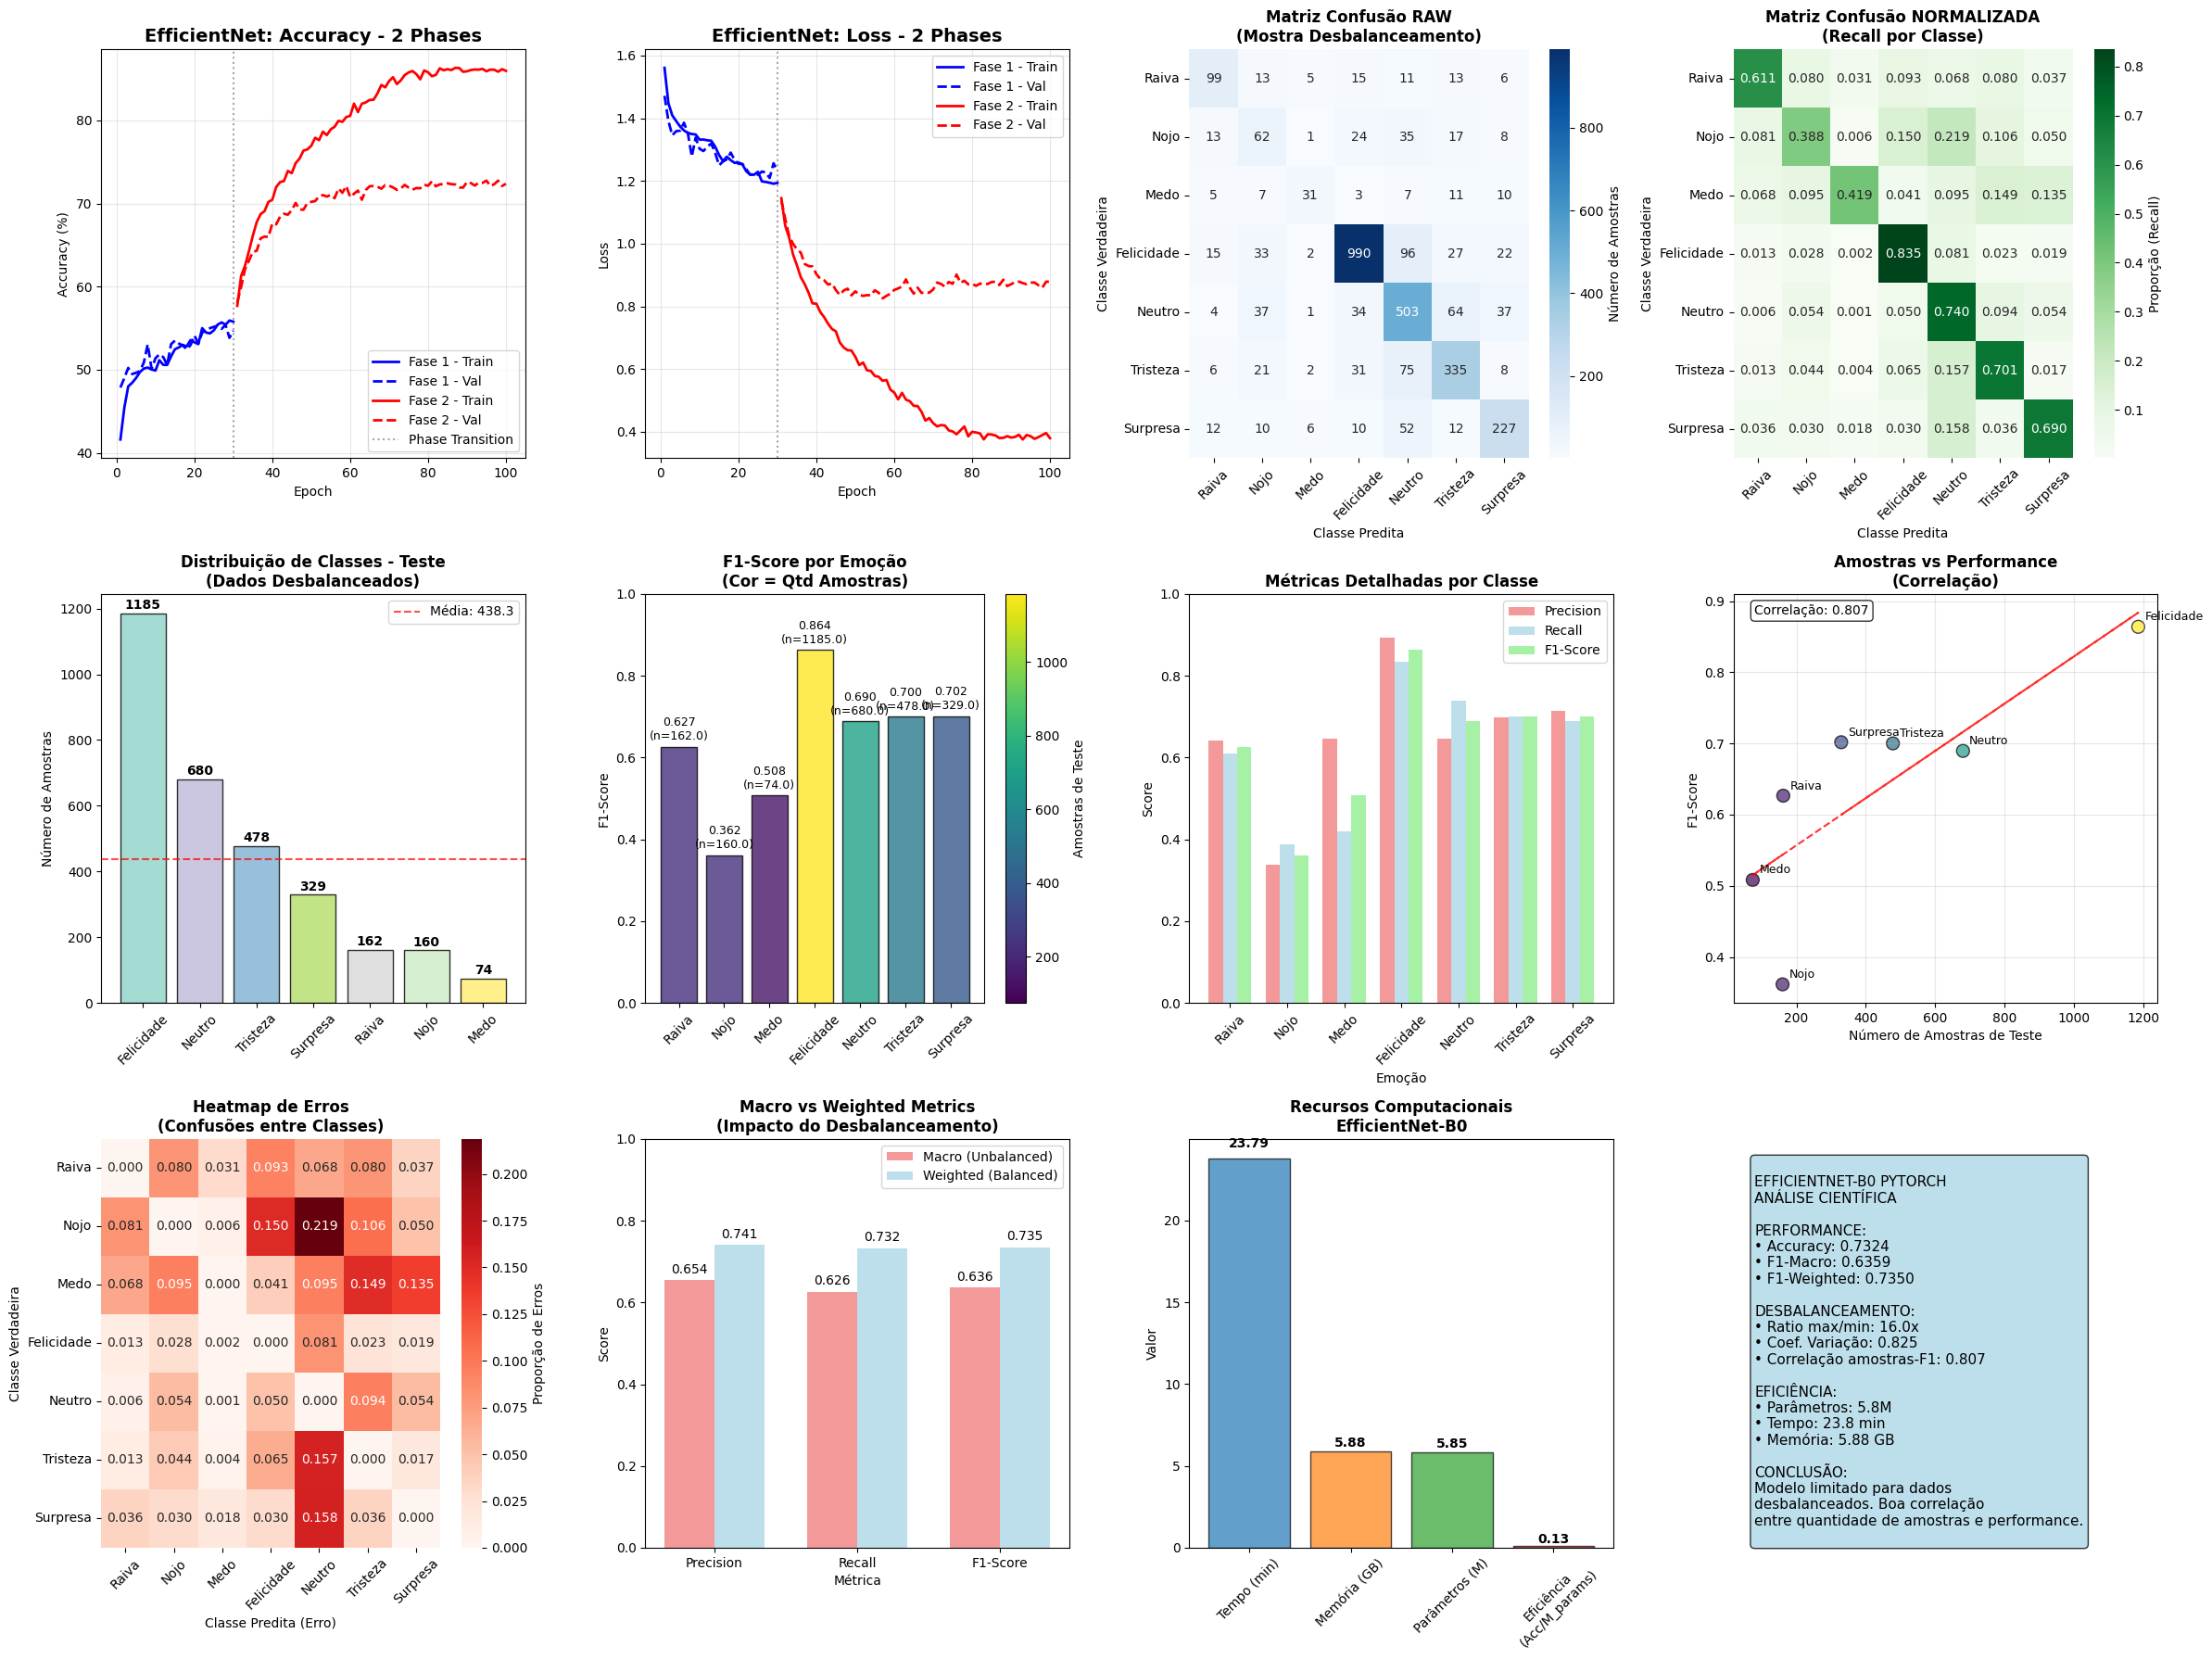


ANÁLISE DETALHADA - DADOS DESBALANCEADOS
DISTRIBUIÇÃO DE CLASSES:
  • Raiva: 162 amostras (5.3%)
  • Nojo: 160 amostras (5.2%)
  • Medo: 74 amostras (2.4%)
  • Felicidade: 1185 amostras (38.6%)
  • Neutro: 680 amostras (22.2%)
  • Tristeza: 478 amostras (15.6%)
  • Surpresa: 329 amostras (10.7%)

ESTATÍSTICAS DE DESBALANCEAMENTO:
  • Ratio máximo/mínimo: 16.01x
  • Desvio padrão: 361.7 amostras
  • Coeficiente de variação: 0.825
  • Classe majoritária: Felicidade (1185 amostras)
  • Classe minoritária: Medo (74 amostras)

IMPACTO NA PERFORMANCE:
  • Correlação amostras-F1: 0.807
    → FORTE correlação positiva: mais amostras = melhor F1
  • Melhor F1: Felicidade (0.864) - 1185.0 amostras
  • Pior F1: Nojo (0.362) - 160.0 amostras

MAIORES CONFUSÕES:
  • Nojo → Neutro: 0.219
  • Nojo → Neutro: 0.219
  • Surpresa → Neutro: 0.158
  • Tristeza → Neutro: 0.157

RECOMENDAÇÕES:
  • Desbalanceamento SEVERO - considere técnicas de balanceamento
  • Sugestões: SMOTE, class weighting, focal loss

In [39]:
# Example usage
if __name__ == "__main__":
    # Initialize monitor
    monitor = EfficientNetMonitor()
    monitor.start_monitoring()
    
    # Generate experiment ID
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    experiment_id = f"efficientnet_pytorch_emotion_{timestamp}"
    
    # Create output directories
    os.makedirs('plots/efficientnet', exist_ok=True)
    os.makedirs('models/efficientnet', exist_ok=True)
    os.makedirs('metrics/efficientnet', exist_ok=True)
    
    print(f"Experiment ID: {experiment_id}")
    
    # Load data
    print("Loading data...")
    X_train, y_train, X_test, y_test = load_preprocessed_data_efficientnet_from_images()
    
    if X_train is not None:
        # Split training data into train and validation
        X_train_split, X_val, y_train_split, y_val = train_test_split(
            X_train, y_train,
            test_size=VALIDATION_SPLIT,
            stratify=y_train,
            random_state=42
        )
        
        print(f"Data split:")
        print(f"  • Train: {X_train_split.shape}")
        print(f"  • Validation: {X_val.shape}")
        print(f"  • Test: {X_test.shape}")
        
        # Analyze data distribution
        print(f"\nData distribution analysis:")
        unique_train, counts_train = np.unique(y_train_split, return_counts=True)
        unique_test, counts_test = np.unique(y_test, return_counts=True)
        
        emotion_names = list(EMOTION_LABELS.keys())
        print("Training set:")
        for i, count in enumerate(counts_train):
            print(f"  • {emotion_names[i]}: {count} samples")
        
        print("Test set:")
        for i, count in enumerate(counts_test):
            print(f"  • {emotion_names[i]}: {count} samples")
        
        test_imbalance_ratio = max(counts_test) / min(counts_test)
        print(f"Test set imbalance ratio: {test_imbalance_ratio:.1f}:1")
        
        # Create data loaders
        train_loader, val_loader, test_loader = create_data_loaders(
            X_train_split, y_train_split, X_val, y_val, X_test, y_test
        )
        
        # Create model
        print("\nCreating EfficientNet-B0 model...")
        model = EfficientNetEmotionClassifier(num_classes=7, dropout_rate=EFFICIENTNET_CONFIG['dropout_rate'])
        model = model.to(device)
        
        # Print model info
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        print(f"EfficientNet-B0 created successfully:")
        print(f"  • Total parameters: {total_params:,}")
        print(f"  • Trainable parameters: {trainable_params:,}")
        print(f"  • Efficiency: {total_params/1000000:.1f}M parameters")
        print(f"  • Trainable ratio: {(trainable_params/total_params)*100:.1f}%")
        
        # Update monitor with GPU memory if available
        if torch.cuda.is_available():
            initial_gpu_memory = torch.cuda.memory_allocated() / 1024**2  # MB
            print(f"  • Initial GPU memory: {initial_gpu_memory:.1f} MB")
        
        # Train model
        print("\n" + "="*60)
        print("STARTING TRAINING")
        print("="*60)
        history = train_efficientnet_two_phase(model, train_loader, val_loader, monitor)
        
        # Load best model for evaluation
        if os.path.exists('best_efficientnet_model.pth'):
            model.load_state_dict(torch.load('best_efficientnet_model.pth'))
            print("Loaded best model weights for evaluation")
        
        # Update memory tracking
        monitor.update_peak_memory()
        if torch.cuda.is_available():
            peak_gpu_memory = torch.cuda.max_memory_allocated() / 1024**2  # MB
            print(f"Peak GPU memory: {peak_gpu_memory:.1f} MB")
        
        # Comprehensive evaluation and visualization
        print("\n" + "="*60)
        print("CREATING COMPREHENSIVE ANALYSIS")
        print("="*60)
        
        # Enhanced evaluation with visualization
        from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
        
        # Detailed evaluation
        model.eval()
        all_preds = []
        all_targets = []
        inference_times = []
        
        print("Measuring inference performance...")
        with torch.no_grad():
            for i, (data, target) in enumerate(test_loader):
                start_time = time.time()
                data, target = data.to(device), target.to(device)
                output = model(data)
                inference_time = time.time() - start_time
                inference_times.append(inference_time)
                
                _, predicted = output.max(1)
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
        
        # Calculate comprehensive metrics
        accuracy = accuracy_score(all_targets, all_preds)
        precision, recall, f1, support = precision_recall_fscore_support(
            all_targets, all_preds, average='macro', zero_division=0
        )
        
        # Weighted metrics for imbalanced data
        precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
            all_targets, all_preds, average='weighted', zero_division=0
        )
        
        conf_matrix = confusion_matrix(all_targets, all_preds)
        class_report = classification_report(
            all_targets, all_preds,
            target_names=emotion_names,
            output_dict=True
        )
        
        # Compile comprehensive metrics
        avg_inference_time = np.mean(inference_times)
        total_inference_time = sum(inference_times)
        samples_per_second = len(all_targets) / total_inference_time
        
        metrics = {
            'experiment_id': experiment_id,
            'test_accuracy': accuracy,
            'f1_score_macro': f1,
            'f1_score_weighted': f1_weighted,
            'precision_macro': precision,
            'precision_weighted': precision_weighted,
            'recall_macro': recall,
            'recall_weighted': recall_weighted,
            'training_time_seconds': history['phase1_duration'] + history['phase2_duration'],
            'phase1_duration': history['phase1_duration'],
            'phase2_duration': history['phase2_duration'],
            'peak_memory_mb': monitor.peak_memory_mb,
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'avg_inference_time_seconds': avg_inference_time,
            'samples_per_second': samples_per_second,
            'test_samples': len(all_targets),
            'imbalance_ratio': test_imbalance_ratio,
            'best_val_acc_phase1': history['best_val_acc_phase1'],
            'best_val_acc_phase2': history['best_val_acc_phase2']
        }
        
        # Print results
        print(f"\nCOMPREHENSIVE RESULTS:")
        print(f"  • Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"  • F1-Score (Macro): {f1:.4f}")
        print(f"  • F1-Score (Weighted): {f1_weighted:.4f}")
        print(f"  • Precision (Macro): {precision:.4f}")
        print(f"  • Recall (Macro): {recall:.4f}")
        print(f"  • Inference Speed: {samples_per_second:.1f} samples/second")
        print(f"  • Total Training Time: {timedelta(seconds=int(metrics['training_time_seconds']))}")
        
        # Create comprehensive visualizations with imbalance analysis
        print("\nGenerating comprehensive visualizations...")
        create_comprehensive_visualizations_efficientnet_pytorch(
            history, conf_matrix, metrics, class_report, experiment_id, all_targets, all_preds
        )
        
        # Save model if performance is good
        performance_threshold = 0.70  # Adjust based on your requirements
        if accuracy >= performance_threshold:
            model_path = f'models/efficientnet/efficientnet_model_{experiment_id}.pth'
            torch.save({
                'model_state_dict': model.state_dict(),
                'metrics': metrics,
                'history': history,
                'model_config': {
                    'num_classes': 7,
                    'dropout_rate': EFFICIENTNET_CONFIG['dropout_rate'],
                    'img_size': IMG_SIZE,
                    'architecture': 'EfficientNet-B0'
                }
            }, model_path)
            print(f"Model saved: {model_path}")
        else:
            print(f"Model not saved (accuracy {accuracy:.4f} < {performance_threshold})")
        
        # Save metrics to CSV
        metrics_df = pd.DataFrame([metrics])
        metrics_csv = f'metrics/efficientnet/efficientnet_metrics_{experiment_id}.csv'
        metrics_df.to_csv(metrics_csv, index=False)
        print(f"Metrics saved: {metrics_csv}")
        
        # End monitoring
        monitor_stats = monitor.end_monitoring()
        
        print("\n" + "="*60)
        print("EXPERIMENT COMPLETED SUCCESSFULLY")
        print("="*60)
        print(f"Experiment ID: {experiment_id}")
        print(f"Files generated:")
        print(f"  • Visualizations: plots/efficientnet/efficientnet_comprehensive_analysis_pytorch_{experiment_id}.png")
        print(f"  • Metrics: {metrics_csv}")
        if accuracy >= performance_threshold:
            print(f"  • Model: models/efficientnet/efficientnet_model_{experiment_id}.pth")
        print(f"  • Best model: best_efficientnet_model.pth")
        
        # Final summary for imbalanced data
        print(f"\nIMBALANCE ANALYSIS SUMMARY:")
        print(f"  • Test set imbalance ratio: {test_imbalance_ratio:.1f}:1")
        print(f"  • Macro F1 (unweighted): {f1:.4f}")
        print(f"  • Weighted F1 (balanced): {f1_weighted:.4f}")
        print(f"  • Performance difference: {abs(f1_weighted - f1):.4f}")
        
        if f1_weighted - f1 > 0.05:
            print("  → Model benefits significantly from class weighting")
        elif abs(f1_weighted - f1) < 0.02:
            print("  → Model is robust to class imbalance")
        else:
            print("  → Moderate impact of class imbalance")
    
    else:
        print("Failed to load data. Please check the data path and directory structure.")
        print("Expected structure: ../data/augmented/raf_db_balanced/train|test/Emotion_Name/*.jpg")